In [28]:
library('spatstat')
library('dplyr')
Sys.setlocale('LC_ALL','C') 
# Load data and metadata
setwd(paste0('/home/micha/Studies/Courses',
             '/Geostatistics-Tal/Final Project/Point pattern statistics/'))
data_cols <- c('station_id','date_time','relialbility',
               'rain_bool','obs_precip','novalue','eor')
gauge_data <- read.csv('gauge_data.csv', col.names=data_cols)
meta_cols <- c('station_id','height','latitude','longitude',
               'from_date','stn_name','province')
gauge_metadata <- read.csv('gauge_metadata.csv', col.names=meta_cols)
head(gauge_data)
head(gauge_metadata)

[1] "LC_CTYPE=C;LC_NUMERIC=C;LC_TIME=C;LC_COLLATE=C;LC_MONETARY=C;LC_MESSAGES=en_US.UTF-8;LC_PAPER=he_IL.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=he_IL.UTF-8;LC_IDENTIFICATION=C"

station_id,date_time,relialbility,rain_bool,obs_precip,novalue,eor
158,2016110101,3,0,0,-999,eor
158,2016110102,3,0,0,-999,eor
158,2016110103,3,0,0,-999,eor
158,2016110104,3,0,0,-999,eor
158,2016110105,3,0,0,-999,eor
158,2016110106,3,0,0,-999,eor


station_id,height,latitude,longitude,from_date,stn_name,province
158,210,50.7840,8.9545,20000701,Amneburg-Rdigheim,
161,75,50.4237,7.4202,20110712,Andernach,
211,200,50.5800,8.4685,20000101,AlarKlein-Altenstdten,
389,436,51.0148,8.4318,20090603,Berleburg,Bad-Arfeld
390,610,50.9837,8.3683,19861126,Berleburg,Bad-Stnzel
535,417,50.0372,7.3079,20040601,Blankenrath,


In [29]:
# Get one hour, and attach metadata
gauge_data_2016110703 <- filter(gauge_data, date_time=='2016110703')
#head(gauge_data_2016110703)
gauges <- merge(gauge_data_2016110703, gauge_metadata, by='station_id', all.y=TRUE)
gauges <- na.omit(gauges)
head(gauges)

station_id,date_time,relialbility,rain_bool,obs_precip,novalue,eor,height,latitude,longitude,from_date,stn_name,province
158,2016110703,3,1,0.3,-999,eor,210,50.7840,8.9545,20000701,Amneburg-Rdigheim,
161,2016110703,3,1,0.0,-999,eor,75,50.4237,7.4202,20110712,Andernach,
211,2016110703,3,1,3.7,-999,eor,200,50.5800,8.4685,20000101,AlarKlein-Altenstdten,
389,2016110703,3,1,0.0,-999,eor,436,51.0148,8.4318,20090603,Berleburg,Bad-Arfeld
390,2016110703,3,1,0.0,-999,eor,610,50.9837,8.3683,19861126,Berleburg,Bad-Stnzel
535,2016110703,3,0,0.0,-999,eor,417,50.0372,7.3079,20040601,Blankenrath,


In [30]:
# Convert to ppp
gauges_owin <- ripras(gauges$longitude, gauges$latitude, shape="rectangle")
gauges_marks <- gauges$obs_precip
gauges_ppp <- ppp(gauges$longitude, gauges$latitude, 
                  window=gauges_owin,
                  marks=gauges_marks)
#str(gauges_ppp)
#class(gauges_ppp)

# Check overall intensity
print(summary(gauges_ppp)$intensity)

[1] 24.70659


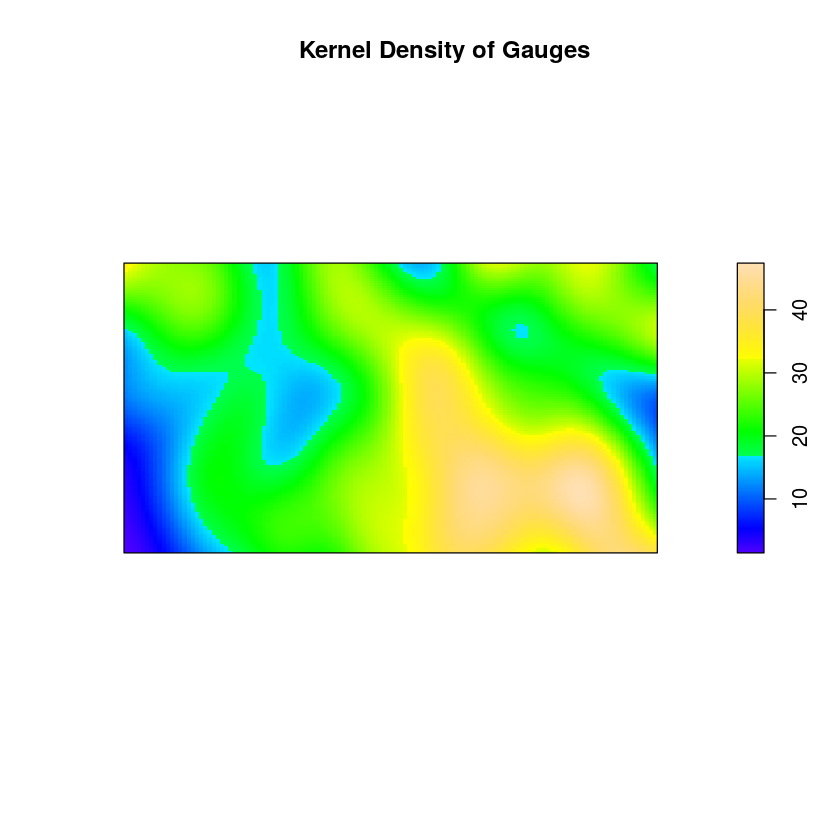

In [31]:
# Get point density and do Kolmogorov-Smirnov
gauges_dens <- density(gauges_ppp)
plot(gauges_dens, main='Kernel Density of Gauges')

Warning message in kstest.ppp(gauges_ppp, gauges_dens):
"marks ignored"

[1] 1.058125e-05


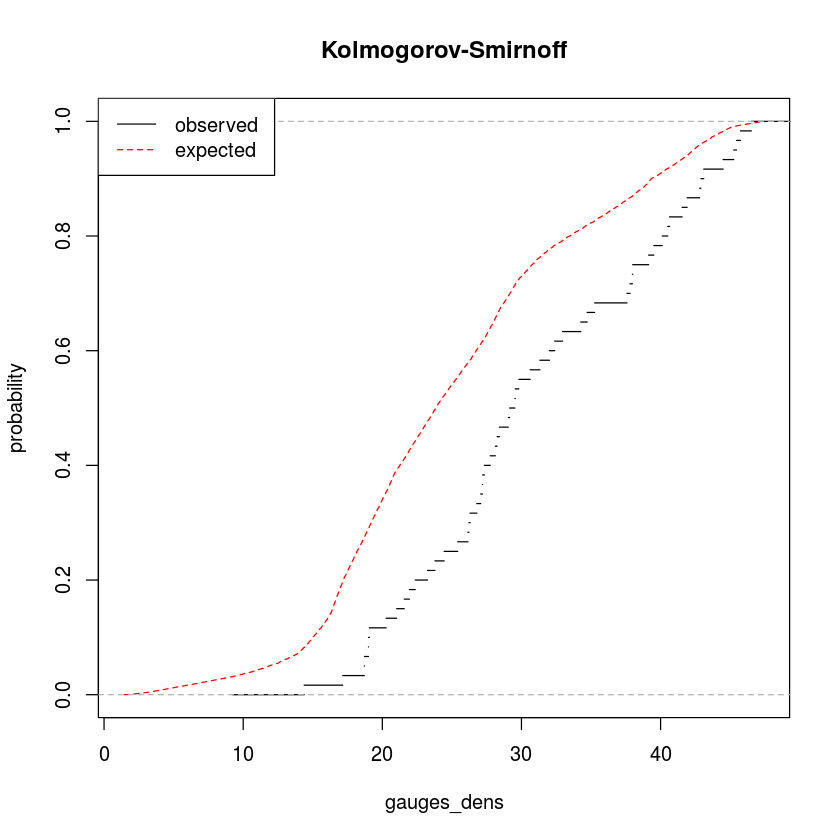

In [32]:
gauges_ks <- kstest(gauges_ppp, gauges_dens)
print(gauges_ks$p.value)
plot(gauges_ks, main="Kolmogorov-Smirnoff")

,lty,col,key,label,meaning
iso,1,1,iso,hat(K)[iso](r),isotropic-corrected estimate of K(r)
theo,2,2,theo,K[pois](r),theoretical Poisson K(r)


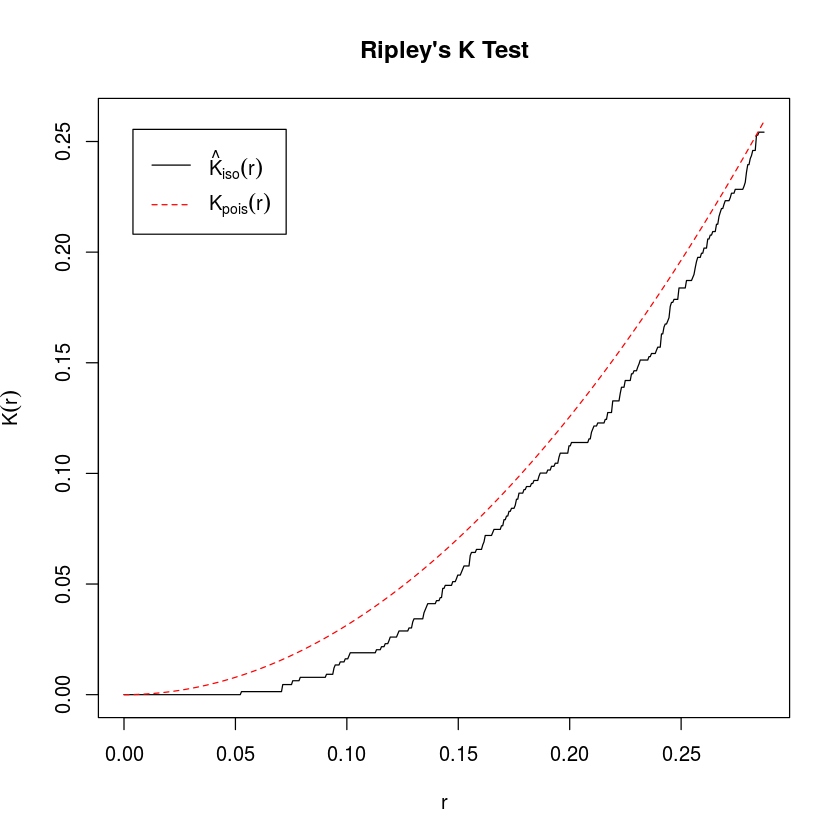

In [33]:
# Ripley's K test
gauges_fv <- Kest(gauges_ppp, correction=c("best"), var.approx=TRUE)
plot(gauges_fv, main="Ripley's K Test")

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


,lty,col,key,label,meaning
obs,1,1,obs,hat(K)[obs](r),observed value of K(r) for data pattern
theo,2,2,theo,K[theo](r),theoretical value of K(r) for CSR
hi,1,8,hi,hat(K)[hi](r),upper pointwise envelope of K(r) from simulations
lo,1,8,lo,hat(K)[lo](r),lower pointwise envelope of K(r) from simulations


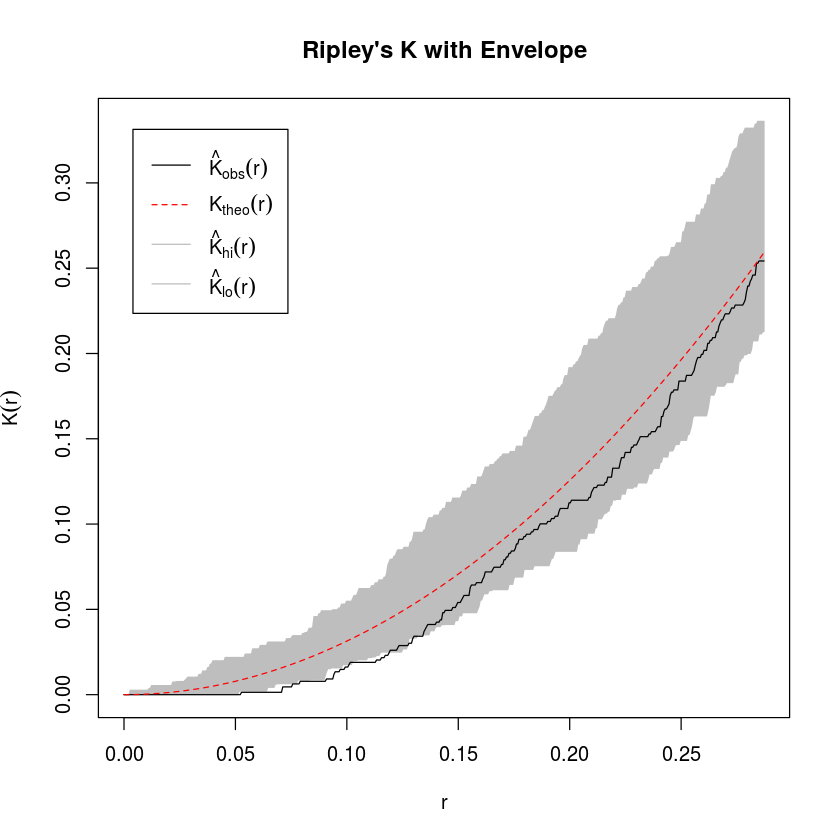

In [34]:
plot(envelope(gauges_ppp, Kest, 99), main="Ripley's K with Envelope")

Generating 99 simulations of CSR  ...
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
91, 92, 93, 94, 95, 96, 97, 98,  99.

Done.


,lty,col,key,label,meaning
obs,1,1,obs,hat(L)[obs](r),observed value of L(r) for data pattern
theo,2,2,theo,L[theo](r),theoretical value of L(r) for CSR
hi,1,8,hi,hat(L)[hi](r),upper pointwise envelope of L(r) from simulations
lo,1,8,lo,hat(L)[lo](r),lower pointwise envelope of L(r) from simulations


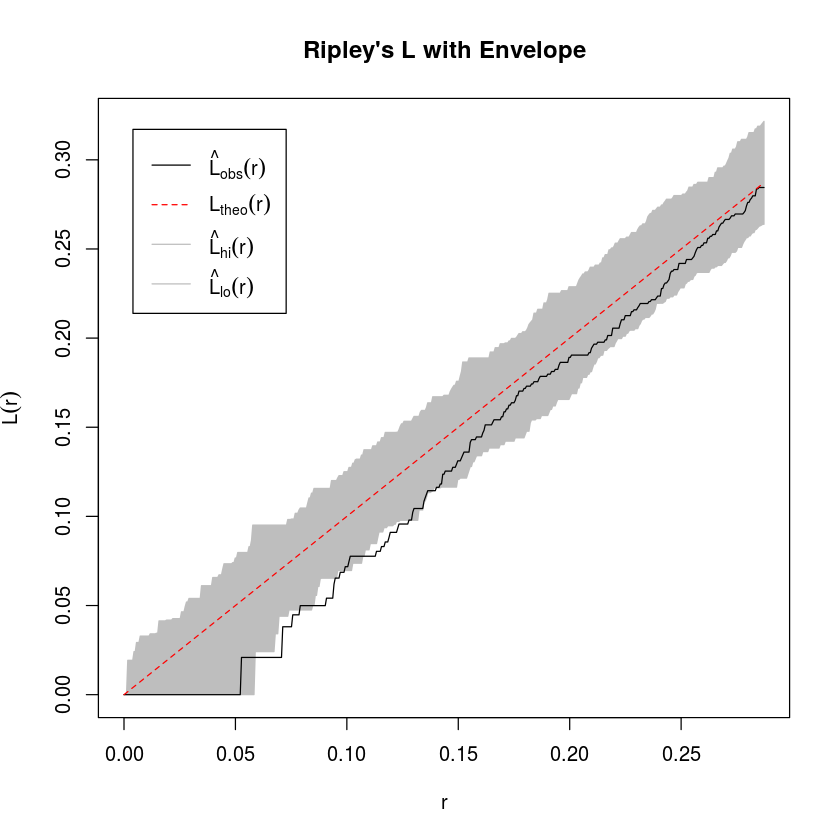

In [26]:
gauges_l <- Lest(gauges_ppp, correction="Ripley")
#plot(gauges_l, main="Ripley's L function")
plot(envelope(gauges_ppp, Lest, 99), main="Ripley's L with Envelope")